<a href="https://colab.research.google.com/github/fatemehalipour/PyTorch-for-Deep-Learning/blob/main/4_Custom_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. PyTorch Custom Datasets

We've used some dataset with PyTorch before.

But how do you get your own data into PyTorch?

One of the ways to do so is via: custom datasets.

Depending on what you are working on, vision, text, audio, recommendation, you want to look into each of the PyTorch domain libraries for existing data loading functions and customizable functions.

## 0. Importing PyTorch and setting up device-agnostic


In [ ]:
import torch
from torch import nn

# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get the data

Our dataset is a subset of Food101 dataset.

3 classes of food and 10% of the images (100 images - 75 training, 25 testing)

When starting ML project, it's important to try things on a small scale and then increase when necessary.

The whole point is to speed up how fast you can experiment.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/PyTorch

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/PyTorch


In [ ]:
pwd

'/content/drive/My Drive/PyTorch'

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and unzip it
if image_path.is_dir():
  print(f"{image_path} directory already exists...skipping download")
else:
  print(f"{image_path} does not exist, creating one ...")
  image_path.mkdir(parents=True,
                   exist_ok=True)

# Download
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip")
  print("Downloading data...")
  f.write(request.content)

# Unzip data
# with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
#   print("Unzipping data ...")
#   zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists...skipping download


## 2. Becoming one with the data (data preparation and data exploration)

In [ ]:
import os
def walk_through_dir(dir_path):
  """walks though dir_path returning its content"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi


In [ ]:
# Setup train and testing path
train_dir = image_path / "train"
test_dir = image_path / "test"

### 2.1 Visualizing an image

Let's write some code to:
1. Get all of the image paths
2. Pick a random. iamge path using random.choice()
3. Get image class name uning `pathlib.Path.parent.stem`
4. Open image by Python's library PIL
5. Show the image and print metadata


Random image path: data/pizza_steak_sushi/test/pizza/930553.jpg
Image class: pizza
Image height: 512
Image width: 306


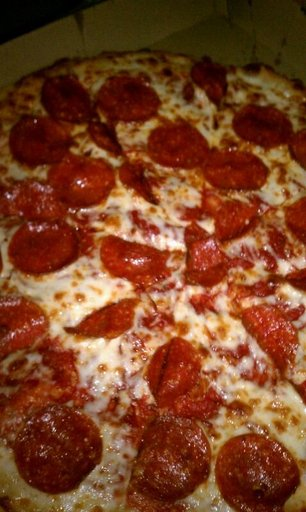

In [ ]:
import random
from PIL import Image

random.seed(42)

# Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Pick a random image path
random_image_path = random.choice(image_path_list)

# Get image class from path name
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

# Print metadara
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

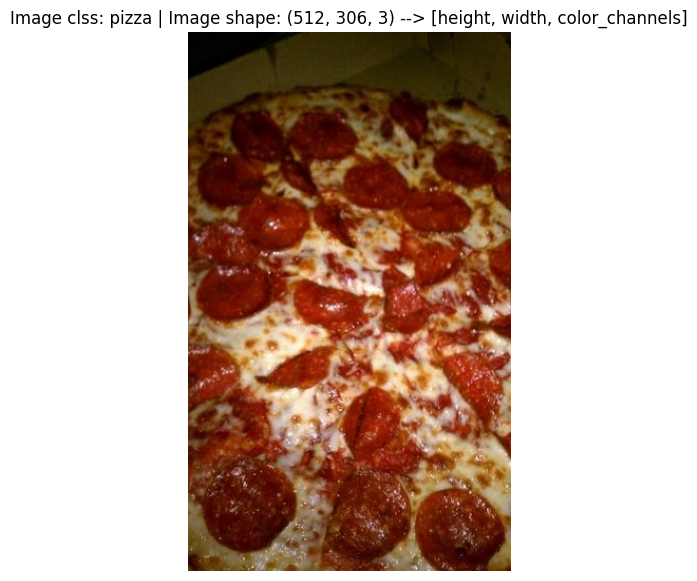

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn image into as array
img_as_array = np.asarray(img)

# Plot the image wiht matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image clss: {image_class} | Image shape: {img_as_array.shape} --> [height, width, color_channels]")
plt.axis(False);


## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (numerical representation of images).
2. Turn into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

###3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation

In [ ]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into tensor
    transforms.ToTensor()
])

In [ ]:
data_transform(img)

tensor([[[0.1059, 0.1529, 0.1725,  ..., 0.0078, 0.0039, 0.0039],
         [0.1137, 0.1765, 0.1804,  ..., 0.0078, 0.0039, 0.0000],
         [0.1882, 0.1961, 0.1843,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.5922, 0.5333, 0.3373,  ..., 0.3843, 0.3686, 0.3765],
         [0.5176, 0.5176, 0.4941,  ..., 0.3608, 0.2588, 0.2118],
         [0.4078, 0.4549, 0.4471,  ..., 0.3059, 0.2275, 0.2314]],

        [[0.0706, 0.1059, 0.1255,  ..., 0.0078, 0.0039, 0.0039],
         [0.0902, 0.1451, 0.1373,  ..., 0.0118, 0.0118, 0.0078],
         [0.1451, 0.1490, 0.1451,  ..., 0.0118, 0.0118, 0.0118],
         ...,
         [0.4745, 0.4118, 0.1922,  ..., 0.2863, 0.2627, 0.2706],
         [0.3922, 0.4078, 0.3725,  ..., 0.2235, 0.1137, 0.0784],
         [0.2118, 0.2941, 0.2941,  ..., 0.1490, 0.0667, 0.0941]],

        [[0.0118, 0.0157, 0.0157,  ..., 0.0000, 0.0000, 0.0000],
         [0.0196, 0.0196, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
         [0.0078, 0.0078, 0.0078,  ..., 0.0000, 0.0000, 0.

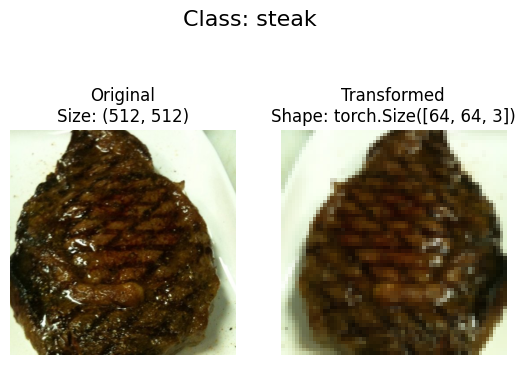

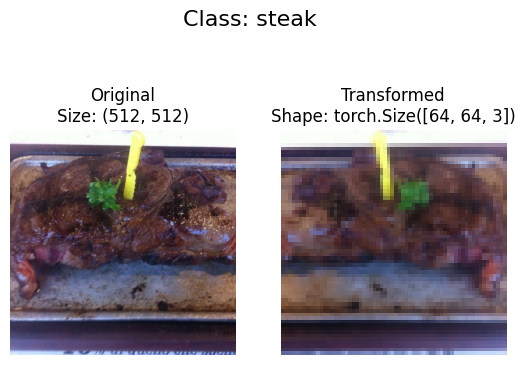

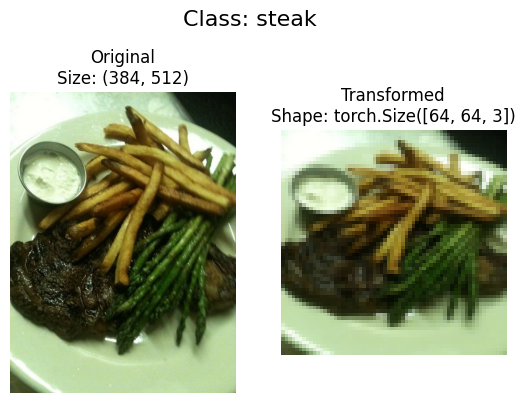

In [ ]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs the original transformed version.
  """
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # not we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)


## 4. Option 1: Loading image dta using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [ ]:
train_dir

PosixPath('data/pizza_steak_sushi/train')

In [ ]:
# use ImageFolder to create datatset(s)
from torchvision.datasets import ImageFolder
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target
test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# Get class names
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the length of our dataset
len(train_data), len(test_data)

(225, 75)

In [ ]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [ ]:
# Index on the train_data Dataset to get a single image and label
image, label = train_data[100]
print(f"Image tensor:\n {image}")
print(f"Image shape: {image.shape}")
print(f"Image datatype: {image.dtype}")
print(f"Image label: {label}")
print(f"Image label datatype: {type(label)}")

Image tensor:
 tensor([[[0.8824, 0.8784, 0.8824,  ..., 0.9490, 0.9725, 0.9804],
         [0.8863, 0.8824, 0.8784,  ..., 0.9294, 0.9569, 0.9725],
         [0.8824, 0.8863, 0.8824,  ..., 0.9294, 0.9451, 0.9608],
         ...,
         [0.6706, 0.6627, 0.6588,  ..., 0.6588, 0.6588, 0.6627],
         [0.6667, 0.6627, 0.6588,  ..., 0.6627, 0.6627, 0.6980],
         [0.6706, 0.6549, 0.6588,  ..., 0.6667, 0.7020, 0.8039]],

        [[0.7765, 0.7725, 0.7686,  ..., 0.7569, 0.8000, 0.8118],
         [0.7725, 0.7686, 0.7686,  ..., 0.7490, 0.7843, 0.8039],
         [0.7686, 0.7686, 0.7686,  ..., 0.7529, 0.7765, 0.8000],
         ...,
         [0.5608, 0.5608, 0.5608,  ..., 0.5294, 0.5255, 0.5255],
         [0.5608, 0.5608, 0.5608,  ..., 0.5333, 0.5333, 0.5608],
         [0.5686, 0.5608, 0.5608,  ..., 0.5333, 0.5725, 0.6706]],

        [[0.6980, 0.7020, 0.6980,  ..., 0.6118, 0.6431, 0.6471],
         [0.7020, 0.7020, 0.6980,  ..., 0.6039, 0.6235, 0.6471],
         [0.6980, 0.6980, 0.6863,  ..., 0.6

Original image shape: torch.Size([3, 64, 64]) -> [C, H, W]
Permuted image shape: torch.Size([64, 64, 3]) -> [H, W, C]


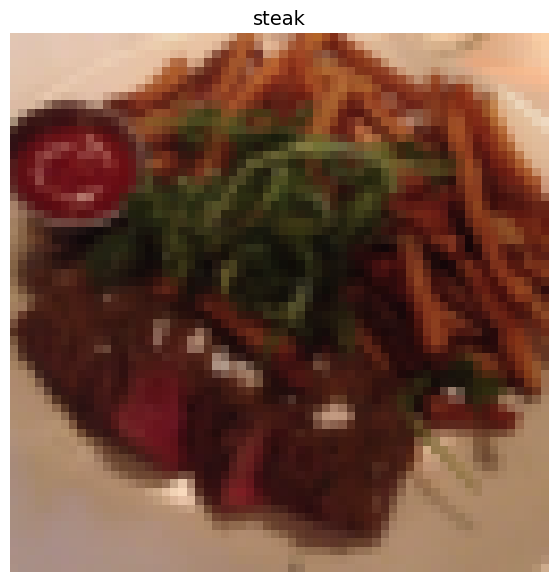

In [ ]:
# Rearrange the ordr of dimensions
img_permute = image.permute(1, 2, 0)

# print out different shapes
print(f"Original image shape: {image.shape} -> [C, H, W]")
print(f"Permuted image shape: {img_permute.shape} -> [H, W, C]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14);

### 4.1 Turn loaded images to `DataLoader`'s

A `DataLoader` is going to help us turn our `Dataset`s into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time.

In [ ]:
import os
os.cpu_count()

2

In [ ]:
# turn train and test datasets to dataloader
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=False)
train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x7d9095f0cdc0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d9095f0cd30>)

In [ ]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a custom `Dataset`

1. Want to able to load images from file
2. Want to get able to get class names form the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Create a `Dataset` out of anything
* You are not limited to PyTorch pre-built `Dataset` function

Cons:
* Even though you could create `Dataset` out of almost anythong, it doesn't mean it will work...
* Often results in us writing more code, which could be prone to errors or performance issues.


All custom datasets in PyTorch, often subclass `torch.utils.data.Dataset`

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a taget directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happen, there might be sth wrong with the directory structure)
3. Turn the class names into a dict and a list and return them.

In [ ]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names form the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """
  Finds the classes folder names in the target directory
  """
  # 1. Get the class names by scanning the target directory
  classes = sorted([entry.name for entry in list(os.scandir(directory))])

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure")

  # 3. Create a dictionary of index labels
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [ ]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to

1. subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the dictionary we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
 * paths - paths of our images
 * transform - the transform we'd like to use
 * classes - a list of target classes
 * class_to_idx - a dict of teh target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of the dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [ ]:
# write a custom dataset
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self, targ_dir: str, transform=None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
    # set up transforms
    self.transform = transform
    # create classes and class_to_ixd
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    """
    Opens an image via a path and returns it
    """
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite the __len__() method
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  # 6. Overwrite the __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    """
    Returns one sample of data, data and label (X, y).
    """
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx #return data, label (X, y)
    else:
      return img, class_idx # return untranformed data and label

In [ ]:
# Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [ ]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [ ]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
train_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
print(train_data.classes==train_data_custom.classes)
print(train_data.class_to_idx==train_data_custom.class_to_idx)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and number of other parameters such as class names and how many images to visualize.
2. To prevent the disply getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility.
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop though the random sample images and plot them with matploblib
7. Make sure the dimension of our images line up with matplotlib (HWC)

In [ ]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")

  # 3. set the see
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16,8))

  # 6. Loop through the indexes and plot them
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample]

    # 7. Adjust tensor dimension for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [C, H, W] -> [H, W, C]

    # plot adjusted sample
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)




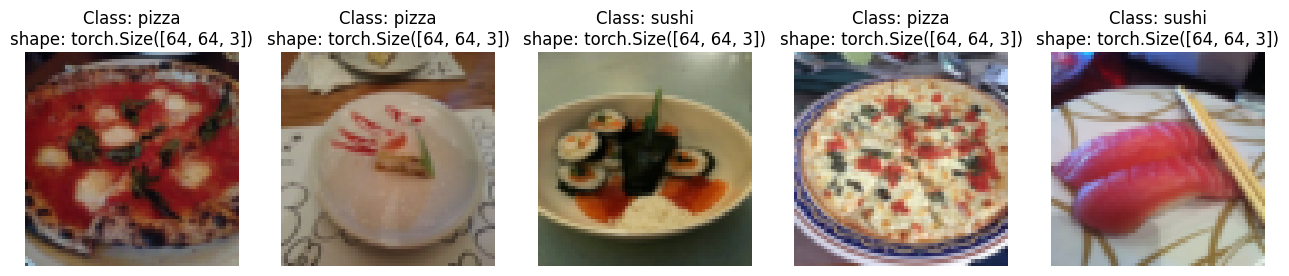

In [ ]:
# Display random images form ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

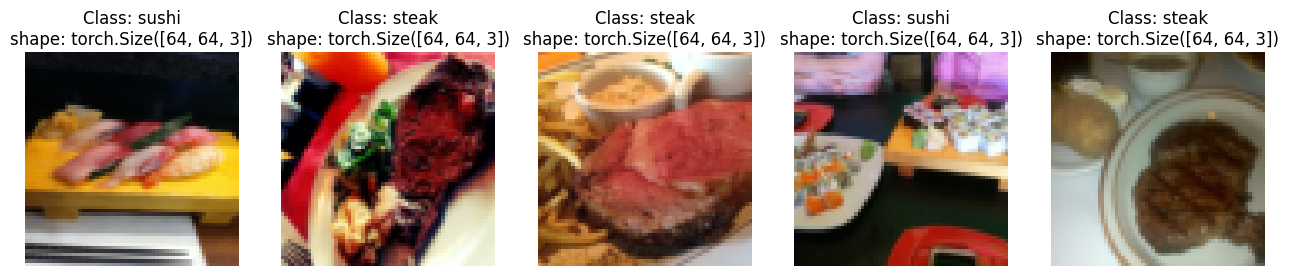

In [ ]:
# Display random images form ImageFolderCustom creted datase
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=42)

### 5.4 Turn custom loaded images into `DataLoader`s

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS, # os.cpu_count()
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7d9090b41c00>,
 <torch.utils.data.dataloader.DataLoader at 0x7d9090b40160>)

In [ ]:
# Get image and label form custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## 6. Other forms of transforms (data augmentation)

Data augmenttion is the process of artificically adding diversity diversity you your training data.

In the case of image data, this may mean applying various image transformations to the training images.

Looking at the same image but from different prespective(s). To artificially increase the diversity of the data.

This practice hopefully results in a model that's more generizable to unseen data.

Let's take a look at on eparticular type of data augmnetation used to train PyTorch vision models to state of the art (sota) levels...

In [ ]:
# Let's look at trivial augment

from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense you want the augmentation be, max = 31
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

In [ ]:
# Get all imape paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/3873283.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/100274.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2117351.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/966174.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1627703.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1882831.jpg')]

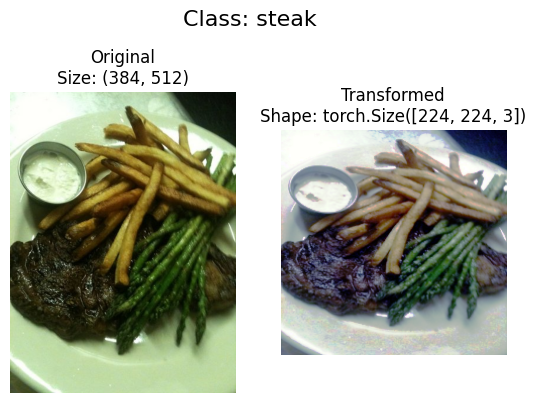

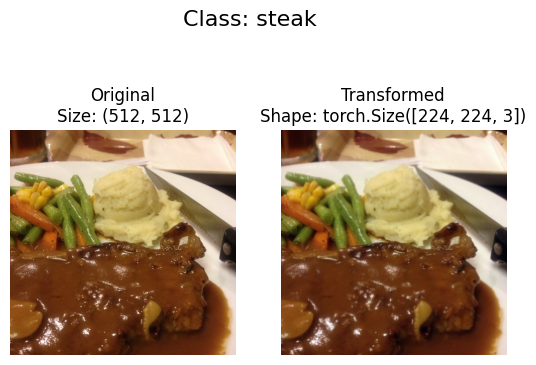

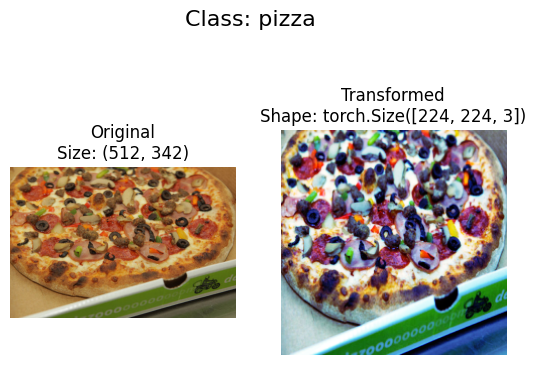

In [ ]:
# plot random transformed images
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=3,
                        seed=None)

## 7. Model 0: TinyVGG without data augmentation

Let's replicate TinyVGG architecture form CNN Explainer website

### 7.1 Create transforms and loading data for Model 0

In [ ]:
# create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [ ]:
# 1. load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the datatsets into DataLoader
import os
from torch.utils.data import DataLoader

# Setup batch size and number od works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG model class

In [ ]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer
  """
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=0,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=0,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape),
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # return slef.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion

In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in put image data
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image

In [ ]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9130e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1470e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.3062e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [ ]:
# install torchinfo, import it if available
try:
  import torchinfo
except:
  !pip install torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loop functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.


In [ ]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  # Put the model in train_mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # adjust metric to get the average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc/ len(dataloader)
  return train_loss, train_acc


In [ ]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy
  test_loss, test_acc = 0, 0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # 3. Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc


### 7.6 Creating a `train()` funcntion to combine `train_step()` and `test_step()`

In [ ]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters, optimizer, loss function, etc.
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):
  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                      dataloader=train_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    # 4. Print what's happening
    print(f"Epoch: {epoch} | Trian loss: {train_loss:.4f} | Train acuuracy: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acuuracy: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

### 7.7 Train and evaluate model 0

In [ ]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                           lr=0.001)

# start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# end the timer
end_time = timer()
total_time = (end_time - start_time)
print(f"Total training time: {total_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Trian loss: 1.1063 | Train acuuracy: 0.3047 | Test loss: 1.0983 | Test acuuracy: 0.3011
Epoch: 1 | Trian loss: 1.0998 | Train acuuracy: 0.3281 | Test loss: 1.0697 | Test acuuracy: 0.5417
Epoch: 2 | Trian loss: 1.0869 | Train acuuracy: 0.4883 | Test loss: 1.0808 | Test acuuracy: 0.4924
Epoch: 3 | Trian loss: 1.0843 | Train acuuracy: 0.4023 | Test loss: 1.0608 | Test acuuracy: 0.5833
Epoch: 4 | Trian loss: 1.0662 | Train acuuracy: 0.4102 | Test loss: 1.0653 | Test acuuracy: 0.5644
Epoch: 5 | Trian loss: 1.0298 | Train acuuracy: 0.4375 | Test loss: 1.0134 | Test acuuracy: 0.5426
Epoch: 6 | Trian loss: 0.9807 | Train acuuracy: 0.4180 | Test loss: 0.9310 | Test acuuracy: 0.6146
Epoch: 7 | Trian loss: 0.9573 | Train acuuracy: 0.5859 | Test loss: 1.0085 | Test acuuracy: 0.4744
Epoch: 8 | Trian loss: 0.9251 | Train acuuracy: 0.5898 | Test loss: 1.0692 | Test acuuracy: 0.3324
Epoch: 9 | Trian loss: 1.0026 | Train acuuracy: 0.4531 | Test loss: 1.0577 | Test acuuracy: 0.4044
Total trai

In [ ]:
model_0_results

{'train_loss': [1.1063191294670105,
  1.0998025238513947,
  1.0868679285049438,
  1.0843231230974197,
  1.066231593489647,
  1.0297838747501373,
  0.9807443171739578,
  0.9572510123252869,
  0.9251025393605232,
  1.0026372447609901],
 'train_acc': [0.3046875,
  0.328125,
  0.48828125,
  0.40234375,
  0.41015625,
  0.4375,
  0.41796875,
  0.5859375,
  0.58984375,
  0.453125],
 'test_loss': [1.0983209212621052,
  1.069698969523112,
  1.08075749874115,
  1.0607823530832927,
  1.0653493404388428,
  1.0133606791496277,
  0.9310216108957926,
  1.0084929664929707,
  1.0691852569580078,
  1.0576607584953308],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394,
  0.5426136363636364,
  0.6145833333333334,
  0.4744318181818182,
  0.33238636363636365,
  0.4043560606060606]}

### 7.8 Plot the loss curve

A **loss curve** is a great way to track you model's progress over time.

A good guide for different loss curve:


In [ ]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curve of a result dictionary"""
  # Get the loss values of the results dictionary (training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary
  acc = results["train_acc"]
  test_acc = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, label="train_accuracy")
  plt.plot(epochs, test_acc, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

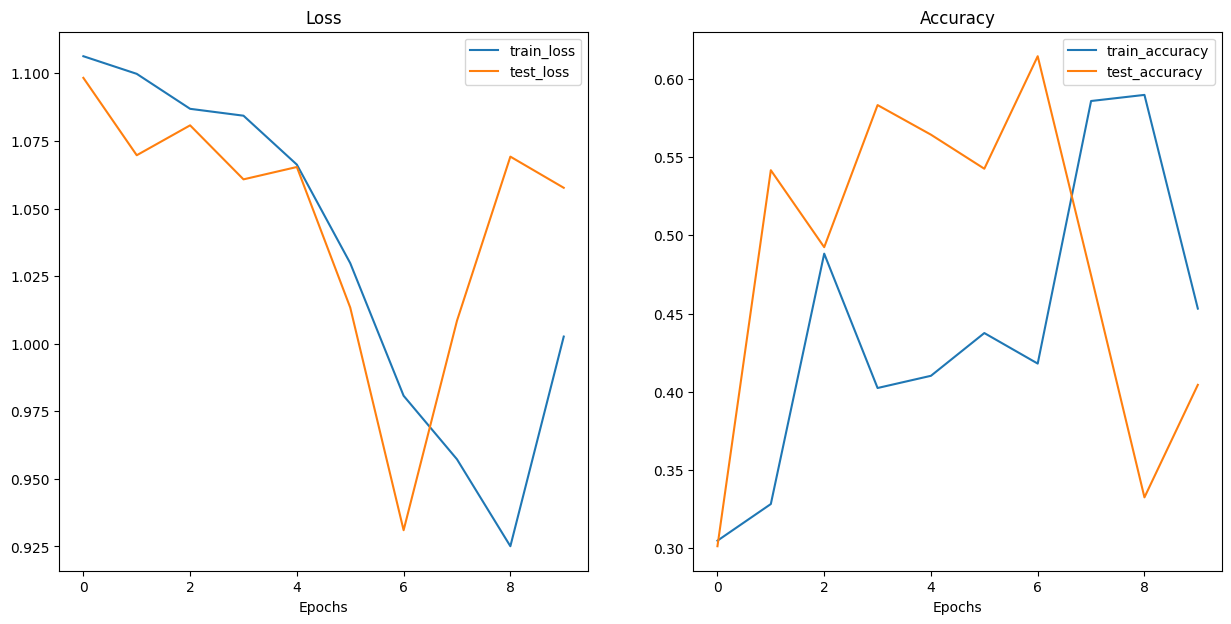

In [ ]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?

A loss curve is one of the most helpful ways to troubleshoot a model.

* Underfitting: train and test loss could be lower
* Overfitting : train loss lower than test loss
* Just right: train and test loss similar

Dealing with overfitting:
* Get more data
* Get data augmentation
* Better data
* Use **transfer learning**
* Simplify your model
* Use learning rate decay: slowly decrease the learning rate as a model trains (coin at the back of the couch)
* Use early stopping: you stop your model from training when the test loss start increasing

Dealing with underfitting:
* Add more layer/units your model
* Tweak the learning rate
* Train for longer (not too long, after some point you overfit)
* Use transfer leaning (pre-learned patterns)
* Use less regularization

## 9. Model 1: TinyVGG Data Augmentation

No let's try anothr modeling experiment this time using the same model as before with some data augmentation.

### 9.1 Create transform with data augmentation

In [ ]:
# Create training transform with TrivialAugment
from torchvision import transforms
train_transforms_trivial = transforms.Compose([
                                              transforms.Resize(size=(64, 64)),
                                              transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                              transforms.ToTensor()
])
test_transforms_simple = transforms.Compose([
                                              transforms.Resize(size=(64, 64)),
                                              transforms.ToTensor()
])

### 9.2 Create train and test datasets and data loader with data augmentation

In [ ]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transforms_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transforms_simple)

In [ ]:
# Turn our datatsets to data loader
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                        num_workers=NUM_WORKERS)

### 9.3 Construct and train model 1

This time we will be using the same model architecture except we've augmented the training data.

In [ ]:
# Create model_1 and send it to target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        device=device)

end_time = timer()
print(f"Total training time for model_1: {end_time - start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Trian loss: 1.1049 | Train acuuracy: 0.2500 | Test loss: 1.1019 | Test acuuracy: 0.2604
Epoch: 1 | Trian loss: 1.0807 | Train acuuracy: 0.4258 | Test loss: 1.1261 | Test acuuracy: 0.2604
Epoch: 2 | Trian loss: 1.0712 | Train acuuracy: 0.4258 | Test loss: 1.1592 | Test acuuracy: 0.2604
Epoch: 3 | Trian loss: 1.1254 | Train acuuracy: 0.3047 | Test loss: 1.1581 | Test acuuracy: 0.2604
Epoch: 4 | Trian loss: 1.0857 | Train acuuracy: 0.4258 | Test loss: 1.1550 | Test acuuracy: 0.3333
Epoch: 5 | Trian loss: 1.0857 | Train acuuracy: 0.3789 | Test loss: 1.1429 | Test acuuracy: 0.2708
Epoch: 6 | Trian loss: 1.0716 | Train acuuracy: 0.5000 | Test loss: 1.1341 | Test acuuracy: 0.3333
Epoch: 7 | Trian loss: 1.0810 | Train acuuracy: 0.3633 | Test loss: 1.1245 | Test acuuracy: 0.3125
Epoch: 8 | Trian loss: 1.0814 | Train acuuracy: 0.4219 | Test loss: 1.0842 | Test acuuracy: 0.3438
Epoch: 9 | Trian loss: 1.0048 | Train acuuracy: 0.4375 | Test loss: 0.9579 | Test acuuracy: 0.5445
Total trai

### 9.4 Plotting loass curve of model_1

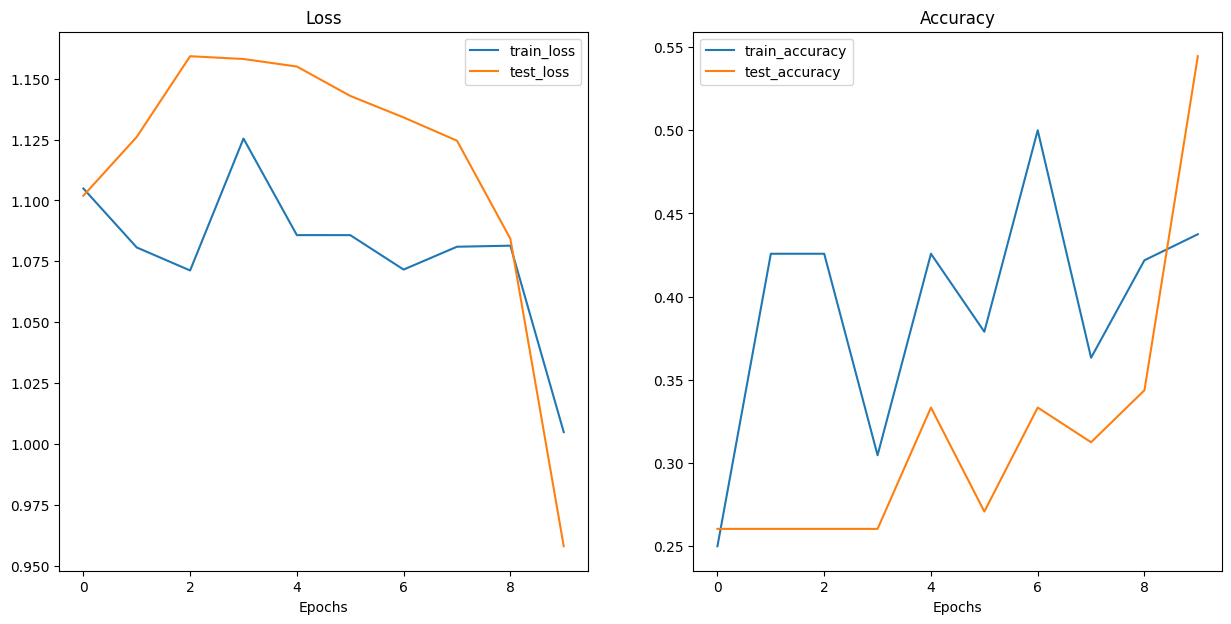

In [ ]:
plot_loss_curves(model_1_results)

## 10. Compare model results

After evaluating our modelling experiments on their own, it's important to compare them to each other.

There's a few different ways to di this:
1. Hard coding (what we're doing)
2. PyTorch + Tensorboard
3. Weights & biases
4. MLFlow

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_1_df

,train_loss,train_acc,test_loss,test_acc
0,1.104914,0.250000,1.101927,0.260417
1,1.080678,0.425781,1.126090,0.260417
2,1.071220,0.425781,1.159245,0.260417
3,1.125418,0.304688,1.158103,0.260417
4,1.085740,0.425781,1.155009,0.333333
5,1.085737,0.378906,1.142936,0.270833
6,1.071592,0.500000,1.134096,0.333333
7,1.080975,0.363281,1.124544,0.312500
8,1.081405,0.421875,1.084239,0.343750
9,1.004804,0.437500,0.957922,0.544508


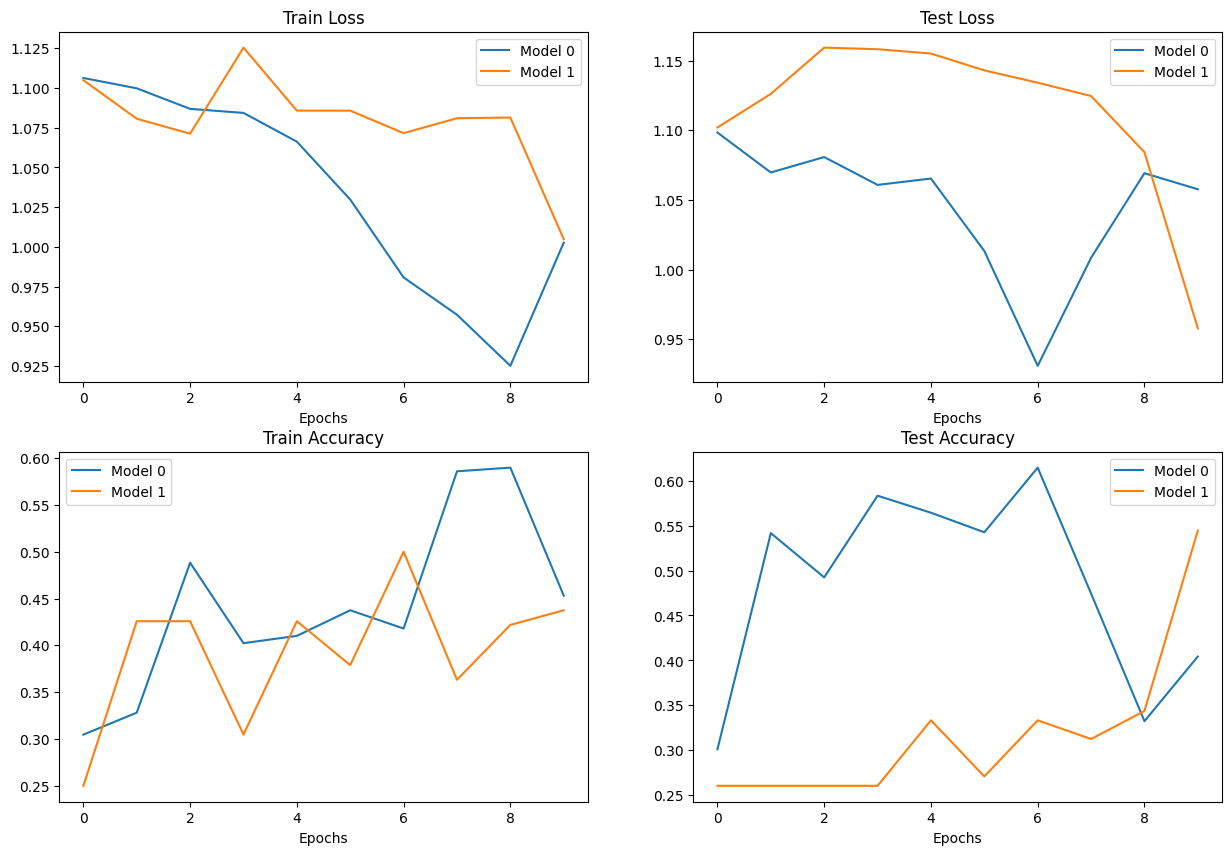

In [ ]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend();

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend();

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## 11. Making a prediction on a custom image

Although we've trianed a model on custom data...how do yoou make a prediction on a sample/image that's not in either training or testing dataset.

In [ ]:
# Download a custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exist. Skip downloading.")

data/04-pizza-dad.jpeg already exist. Skip downloading.


### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with datatype(torch.float32)
* Of shape 64x64x3
* On the right device

We can read an image into PyTorch with `read_image()`

In [ ]:
import torchvision

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custum image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custum image data

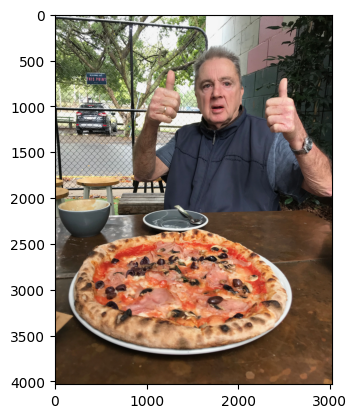

In [ ]:
plt.imshow(custom_image_uint8.permute(1, 2, 0));

### 11.2 Making a prediction on a custom image with a PyTorch model

In [ ]:
# Try to make a prediction on an image in uint8 format
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8.to(device))

RuntimeError: ignored

In [ ]:
# Loading a custom image an dconvert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [ ]:
# Try to make a prediction on an image
model_1.eval()
with torch.inference_mode():
  model_1(custom_image.to(device))

RuntimeError: ignored

In [ ]:
# Create transform pipeline to resize the image
custom_image_transform = transforms.Compose([transforms.Resize(size=(64, 64))])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)
custom_image_transformed.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 64, 64])

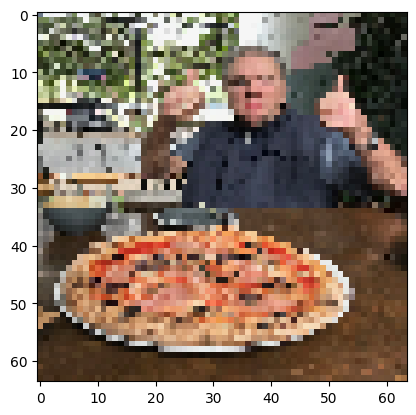

In [ ]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [ ]:
# Try to make a prediction on an image
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: ignored

In [ ]:
# add batch size
custom_image_transformed = custom_image_transformed.unsqueeze(dim=0)
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.to(device))

In [ ]:
class_names[torch.argmax(custom_image_pred)]

'pizza'

Note: to make a prediction on a custom image we had to:
* Load the image and load it to a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data was trained on the model (3, 64, 64) with a batch size (1, 3, 64, 64)
* MAke sure the image was on the same device

In [ ]:
# Convert logits -> prediction probs
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3561, 0.2889, 0.3551]], device='cuda:0')

In [ ]:
# Convert te prediction probs to prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

tensor([0])

In [ ]:
class_names[custom_image_pred_label]

'pizza'

### 11.3 Putting custom image prediction together: building a function

Ideal outcome: A function where we pass an image path and have our model predict on that image and plot the image + prediction

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  """Makes a prediction on a target image with a trained model and plots the image and prediction"""
  # Load image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel values by 255 to get them between [0, 1]
  target_image = target_image / 255

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  # Turn on eval and make prediction
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image (batch dimension)
    target_image = target_image.unsqueeze(0)

    # Make prediction on the image with extra dimension
    target_image_pred = model(target_image.to(device)) # make sure the target image is on the device

  # Let's convert the logits to pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert to prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot th eimage alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0))
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label.cpu()} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


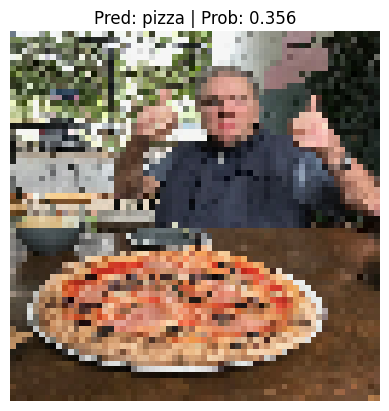

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)